# Decreasing ELBO issue

Possibly caused by comparing and setting prior variances to zero when estimating them.

## Context

I recently implemented EM updates for prior scalar in both MASH regression and  Bayesian multivariate regression (hereafter BMR, essentially MASH with just one component but we have separate, simpler code for it written in R for prototyping purpose). I verified with some tests that for IBSS using MASH mixture with only one matrix the result agree with IBSS using BMR. And BMR, when reduced to just one response, agrees with susieR result. The EM estimate for prior variance scalar are identical and ELBO are non-decreasing. 

## Problem

However, as I moved on to more simulations I get warnings for decreasing ELBO. It seems to happen only when there are many effect variables relative to conditions. For example my toy example below has 2 conditions each having 2 effect variables out of 50 variables. The problem is that not only EM method, but also the "simple" method which estimates prior variance scalar simply by comparing the original to zero and accept whichever has better likelihood, resulted in decreasing ELBO.

This is not the case for SuSiE -- no matter how many effect variables are there, the ELBO is non-decreasing. And at least in my toy example below, estimating the scalar using `optim` also works.

## Possible cause

An interesting observation is that if I switch off the comparison between current estimate and zero at the end of each EM update ([comment out this line](https://github.com/stephenslab/mmbr/blob/390eb23852fa5ed5c17b5062deb6f3e8494ba76e/R/single_effect_model.R#L22)), the algorithm takes longer to converge but ELBO is non-decreasing, is eventually larger than any other approaches, and the estimates make more sense given we know the truth. 

A major difference between EM update and maximizing the single effect loglik directly is that the former is a function of posterior quantities whereas the latter only involves the data, with the prior to be estimated ([here for instance](https://github.com/stephenslab/mmbr/blob/390eb23852fa5ed5c17b5062deb6f3e8494ba76e/R/bayesian_simple_regression.R#L73)). As a result, in EM updates if in a previous iteration sets the estimate to zero then it will impact the posterior of the next iteration and the estimate will never come back from zero. This is not the case for when prior is directly estimated as in `optim`.

However it is still puzzling that `simple` method doesn't work.

## Illustration

Here I use BMR not MASH regression to illustrate.

In [1]:
devtools::load_all('~/GIT/software/mmbr')
set.seed(1)
dat = mmbr_sim1(n=50,p=50,r=2,s=2)
L = 10

Loading mmbr

Loading required package: mashr

Loading required package: ashr



There are 2 conditions, each having 2 effect variables.

In [2]:
sum(rowSums(dat$b)>0)

[1] 4

### Fit without estimating prior

We use fixed prior here provided by simulated data object; everything looks fine:

In [3]:
dat$V

0.46673960,0.05659291
0.05659291,0.50840182


In [4]:
fit0 = msusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=F)

In [5]:
fit0$elbo

[1] -198.0448 -196.0629 -195.7685 -195.6085 -195.3610 -195.2423 -195.2277
[8] -195.2257 -195.2248

In [6]:
fit0$V

[1] 1 1 1 1 1 1 1 1 1 1

### `simple` method

Using `simple` method we see decreasing ELBO, and only 1 out of 4 effects was captured.

In [7]:
fit1 = msusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method = 'simple')

Warning message in m$get_objective(dump = TRUE):
“Objective is not non-decreasing”


In [8]:
fit1$elbo

[1] -182.7855 -182.7855

In [9]:
fit1$V

[1] 1 0 0 0 0 0 0 0 0 0

Notice that with `L = 5` I get the same behavior,

In [10]:
fit11 = msusie(dat$X,dat$y,L=5,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method = 'simple')

Warning message in m$get_objective(dump = TRUE):
“Objective is not non-decreasing”


In [11]:
fit11$elbo

[1] -182.7855 -182.7855

In [12]:
fit11$V

[1] 1 0 0 0 0

### `EM` method

It suffers from the same, or maybe even more so, because the ELBO is worse,

In [13]:
fit2 = msusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method = 'EM')

Warning message in m$get_objective(dump = TRUE):
“Objective is not non-decreasing”


In [14]:
fit2$elbo

[1] -198.0448 -183.8938 -185.0643

In [15]:
fit2$V

[1] 0 0 0 0 0 0 0 0 0 0

However, when I set `L = 5` it seems to work,

In [16]:
fit21 = msusie(dat$X,dat$y,L=5,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method = 'EM')

In [17]:
fit21$elbo

[1] -188.0174 -183.2629 -182.7960 -182.7510 -182.7470 -182.7467

In [18]:
fit21$V

[1] 0.7167625 0.0000000 0.0000000 0.0000000 0.0000000

Although still it sets only the first effect to be non-zero and the signals share the one effect.

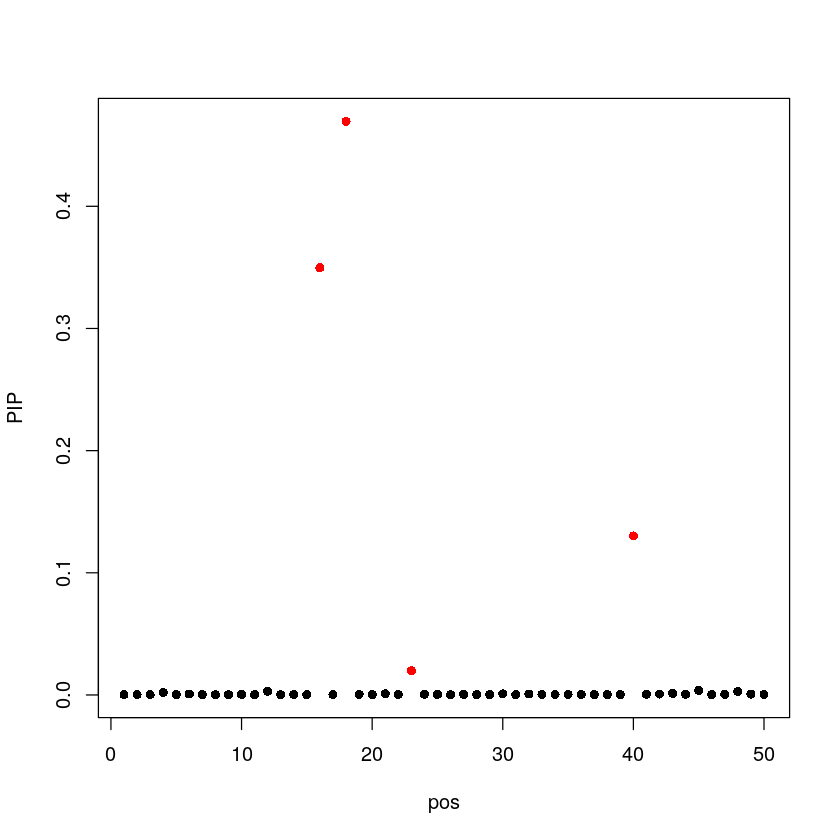

In [19]:
susieR::susie_plot(fit21, 'PIP', b = rowSums(dat$b))

In [22]:
sum(fit21$pip)

[1] 1

### `optim` method

It seems to work at least for this example with `L=10` and the estimate is similar to that produced by `EM` with `L = 5`. Notice that for `optim` method we still have that check at the end of each update comparing current estimate with zero in terms of likelihood. Thus many `V` are set to zero.

In [23]:
fit3 = msusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method = 'optim')

In [24]:
fit3$elbo

[1] -182.7467 -182.7467

In [25]:
fit3$V

[1] 0.7181046 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
 [8] 0.0000000 0.0000000 0.0000000

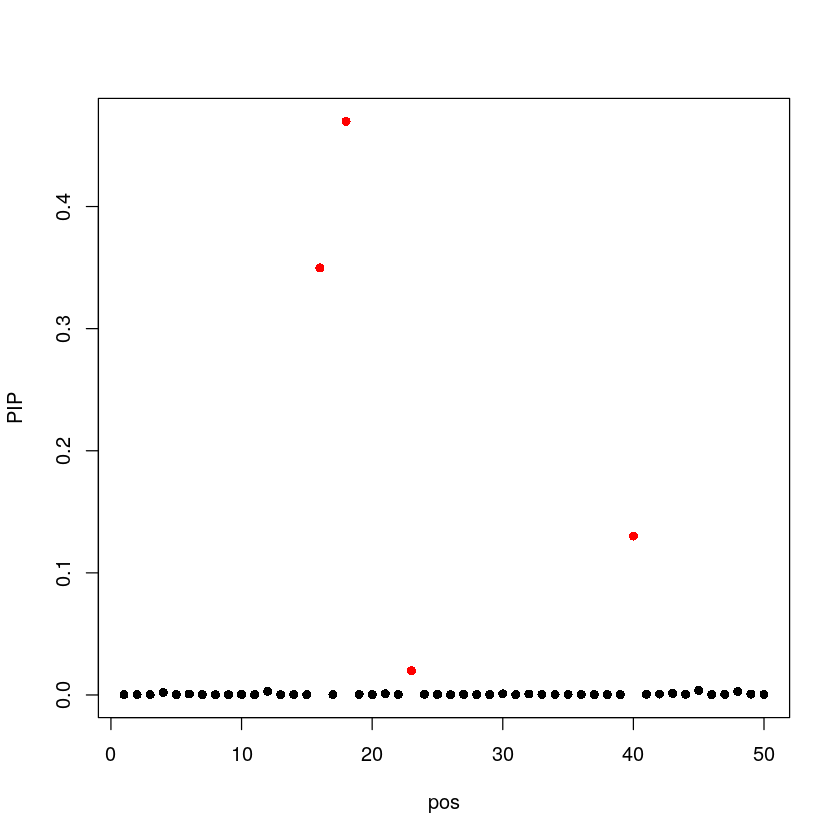

In [26]:
susieR::susie_plot(fit3, 'PIP', b = rowSums(dat$b))

### `EM` update without checking with zero

I commented out [this line](https://github.com/stephenslab/mmbr/blob/390eb23852fa5ed5c17b5062deb6f3e8494ba76e/R/single_effect_model.R#L22)) in my code, and run EM with `L=10`:

In [46]:
devtools::load_all('~/GIT/software/mmbr')

Loading mmbr



In [51]:
fit4 = msusie(dat$X,dat$y,L=L,prior_variance=dat$V, 
              compute_objective=T, estimate_residual_variance=F, 
              estimate_prior_variance=T, estimate_prior_method = 'EM', max_iter = 200)

In [52]:
fit4$elbo

[1] -198.0448 -185.8084 -184.1862 -183.7483 -183.5179 -183.3480 -183.2281
  [8] -183.1588 -183.1223 -183.1008 -183.0856 -183.0732 -183.0623 -183.0522
 [15] -183.0423 -183.0320 -183.0208 -183.0076 -182.9911 -182.9687 -182.9357
 [22] -182.8834 -182.7964 -182.6567 -182.4751 -182.3152 -182.2184 -182.1661
 [29] -182.1327 -182.1063 -182.0833 -182.0625 -182.0435 -182.0260 -182.0099
 [36] -181.9950 -181.9812 -181.9684 -181.9565 -181.9453 -181.9349 -181.9252
 [43] -181.9161 -181.9075 -181.8994 -181.8918 -181.8846 -181.8778 -181.8713
 [50] -181.8652 -181.8594 -181.8539 -181.8486 -181.8436 -181.8388 -181.8343
 [57] -181.8299 -181.8257 -181.8218 -181.8179 -181.8143 -181.8107 -181.8073
 [64] -181.8041 -181.8010 -181.7979 -181.7950 -181.7922 -181.7895 -181.7869
 [71] -181.7844 -181.7820 -181.7796 -181.7773 -181.7751 -181.7730 -181.7709
 [78] -181.7689 -181.7670 -181.7651 -181.7632 -181.7615 -181.7597 -181.7581
 [85] -181.7564 -181.7548 -181.7533 -181.7518 -181.7503 -181.7489 -181.7475
 [92] -181.7461 -181.7448 -181.7435 -181.7423 -181.7410 -181.7398 -181.7387
 [99] -181.7375 -181.7364 -181.7353 -181.7343 -181.7332 -181.7322 -181.7312

In [53]:
fit4$niter

[1] 105

It took 105 iterations to converge but the ELBO -181 is the best ELBO achieved in this document. 

The prior estimates are:

In [54]:
fit4$V

[1] 0.714071253 0.688578702 0.003376494 0.003317388 0.003297329 0.003284211
 [7] 0.003274674 0.003267332 0.003261468 0.003256656

Here it captures 2 effects, as also reflected below that two effects have large PIP,

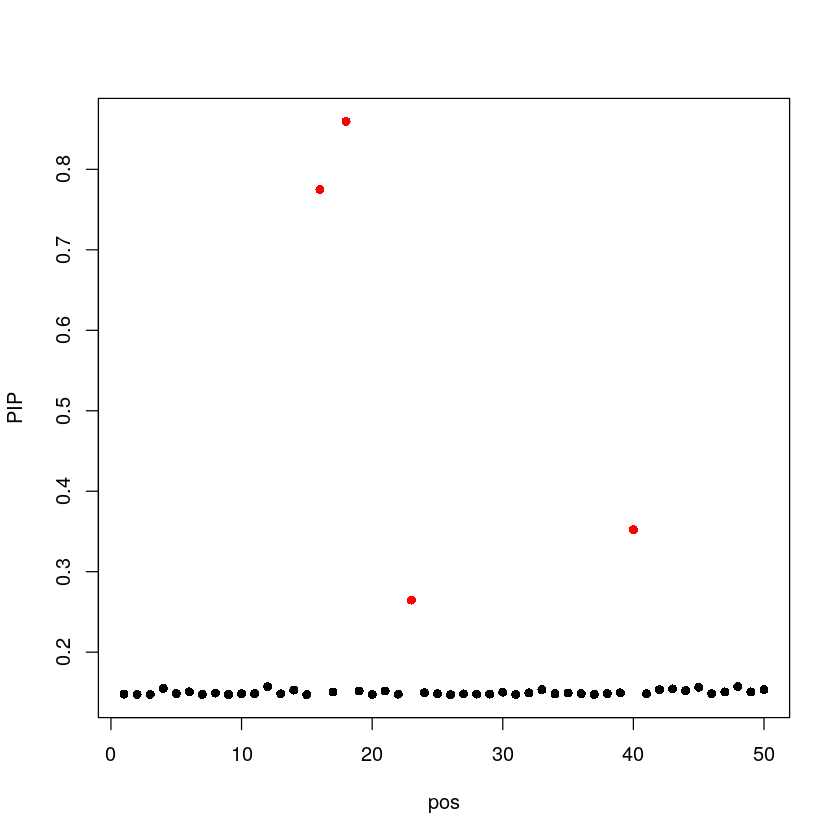

In [58]:
susieR::susie_plot(fit4, 'PIP', b = rowSums(dat$b))